# Importing Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\swarg\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\swarg\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Loading Data

In [2]:
#Loading Data
data = pd.read_csv("C:/Users/swarg/OneDrive/Desktop/KLU/intership/traffic.csv/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


# Data Exploration

In [3]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

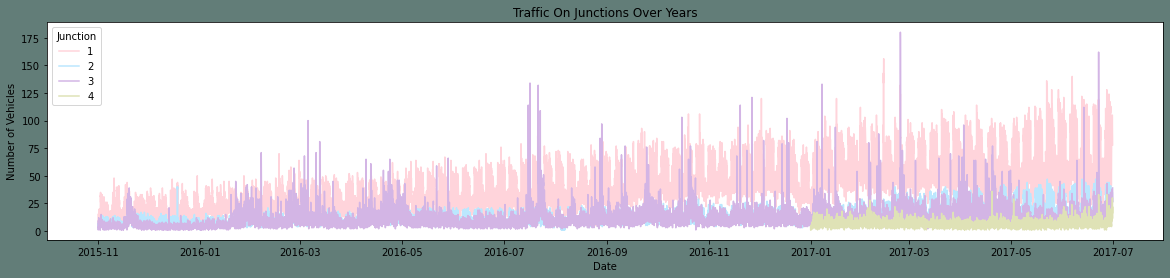

In [4]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

# Feature Engineering

In [5]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


# Exploratory Data Analysis

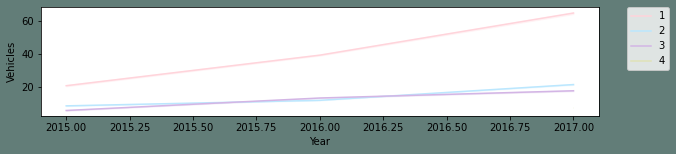

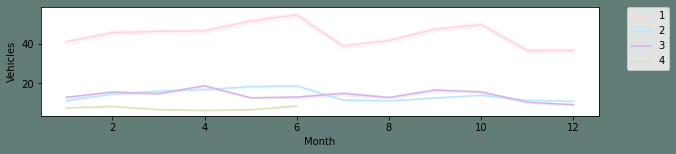

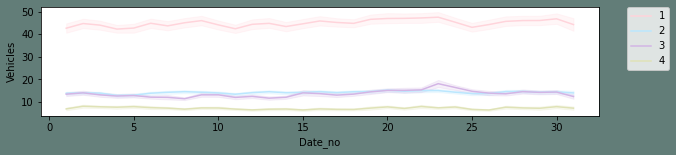

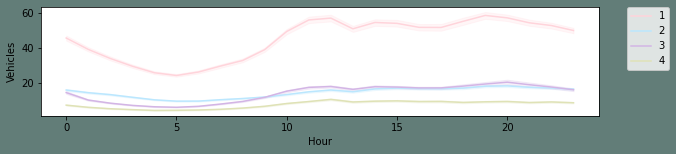

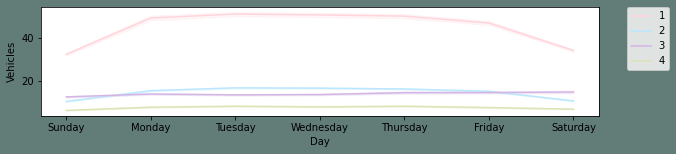

In [6]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

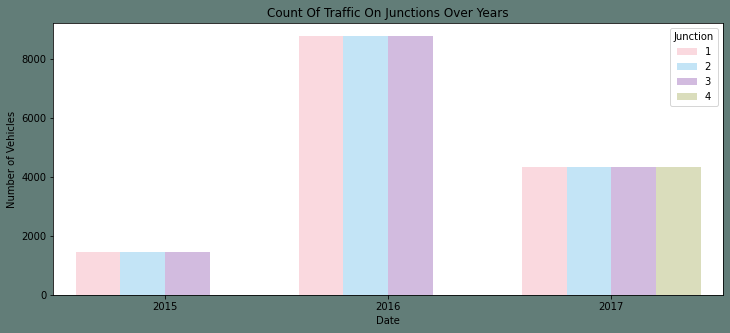

In [7]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

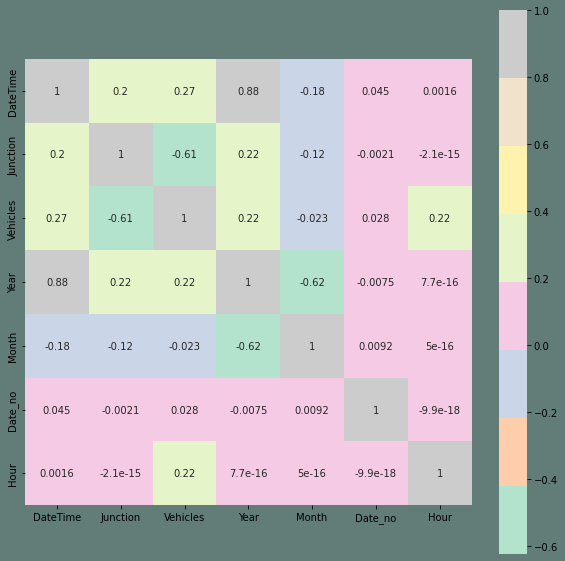

In [11]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

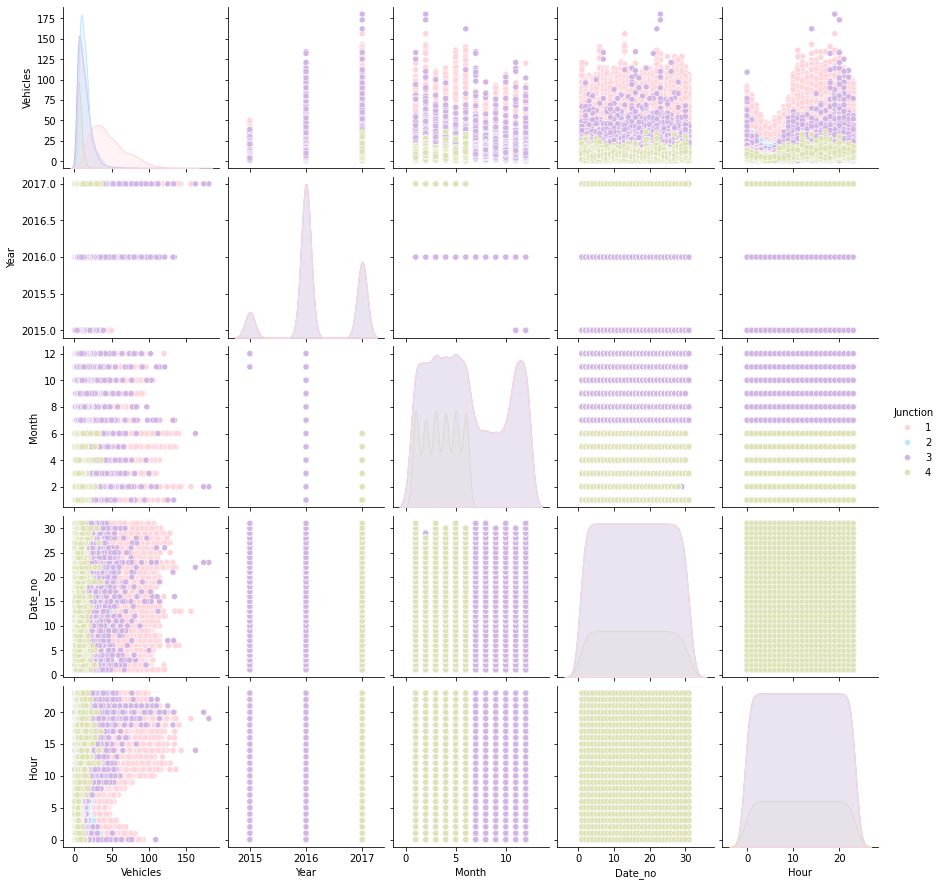

In [12]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

# Data Transformation And Preprocessing

In [13]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

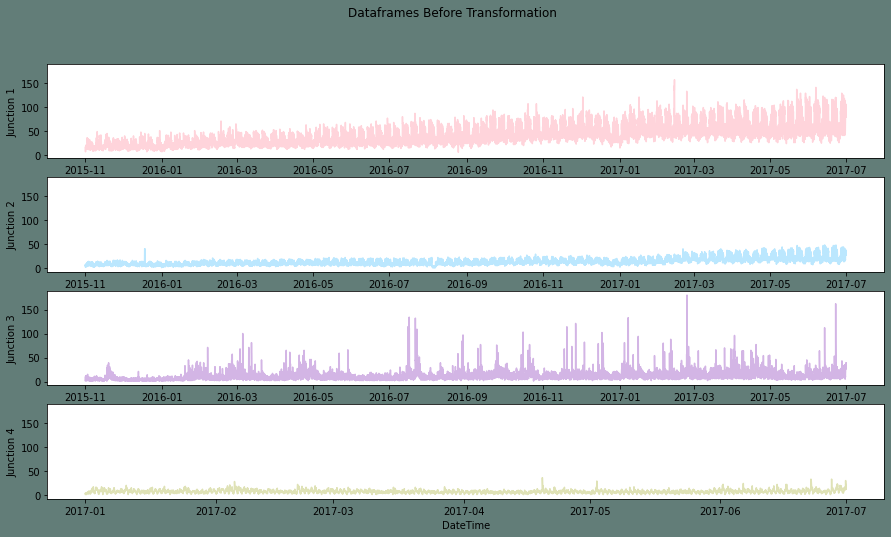

In [14]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [15]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [16]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

#### Plots of Transformed Dataframe

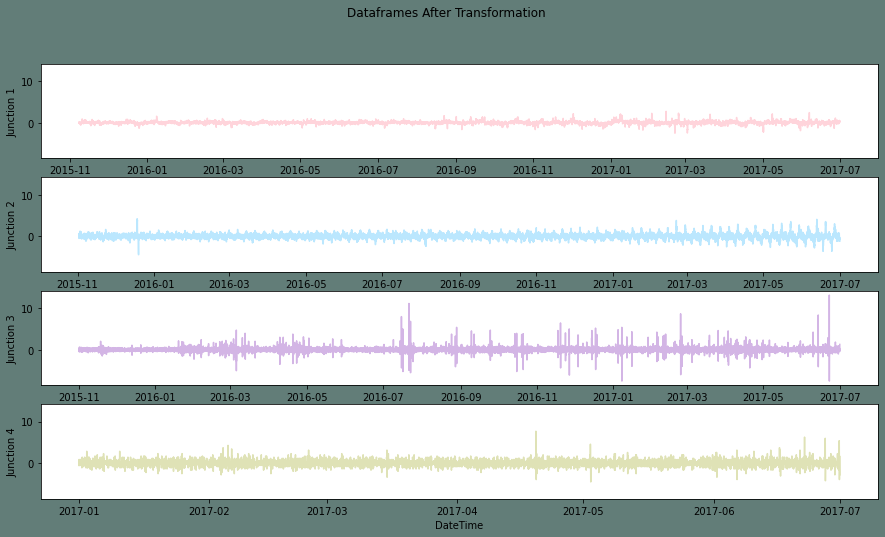

In [17]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


In [18]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415358
p-value: 4.798539876397885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694006
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.0017599088325
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052184
p-value: 2.77878753259558e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [19]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Model Building

In [20]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Fitting The Model

#### Fitting the first junction and plotting the predictions and testset

In [21]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - loss: 0.0879
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 0.0679
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 350ms/step - loss: 0.0667
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - loss: 0.0645
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - loss: 0.0627
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 0.0615
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - loss: 0.0584
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.0597
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 0.0593
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - loss: 0.0556
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - loss: 0.0550
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - loss: 0.0581
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - loss: 0.0548
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 337ms/step - loss: 0.0549
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3996

The root mean squared error is 0.2458320751593122.


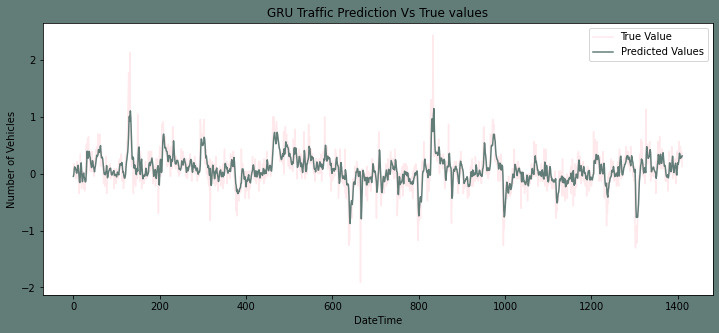

In [22]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

#### Fitting the second junction and plotting the predictions and testset

In [23]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - loss: 0.2848
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 341ms/step - loss: 0.2051
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - loss: 0.1953
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - loss: 0.1955
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 318ms/step - loss: 0.1975
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - loss: 0.1957
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - loss: 0.1931
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - loss: 0.1900
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - loss: 0.1894
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - loss: 0.1924
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - loss: 0.1799
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 435ms/step - loss: 0.1881
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 382ms/step - loss: 0.1873
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/step - loss: 0.1902
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 

The root mean squared error is 0.5564618835748858.


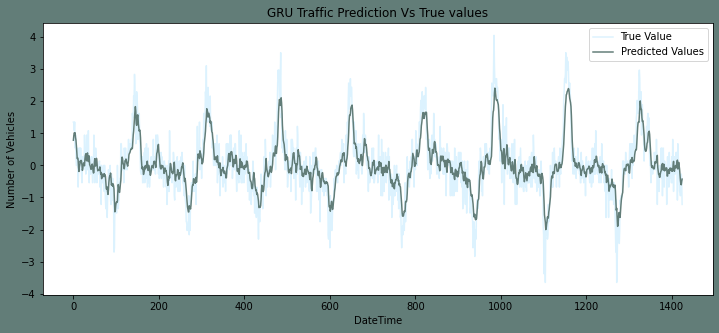

In [24]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

#### Fitting the third junction and plotting the predictions and testset

In [25]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 407ms/step - loss: 0.3142
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 380ms/step - loss: 0.3016
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - loss: 0.2673
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 0.3442
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.2735
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.2820
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.2837
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.2906
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.3002
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.3098
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 0.2951
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - loss: 0.3161
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.2960
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.3201
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 

The root mean squared error is 0.6065746981915513.


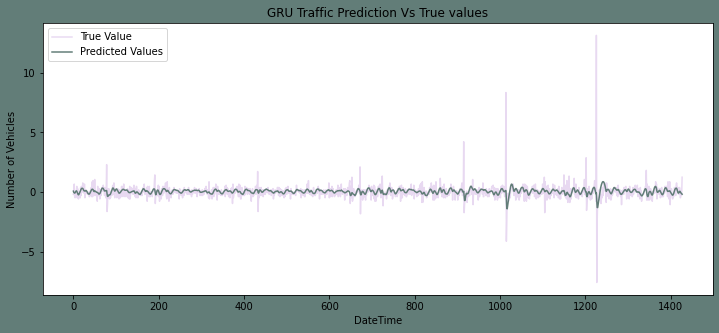

In [26]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

#### Fitting the fourth junction and plotting the predictions and testset

In [27]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.7244
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.6721
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.6444
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.6854
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.6702
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.6803
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.6777
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.7285
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.7558
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.6866
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.6986
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.6811
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.7132
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.6765
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - lo

The root mean squared error is 0.9935615323285402.


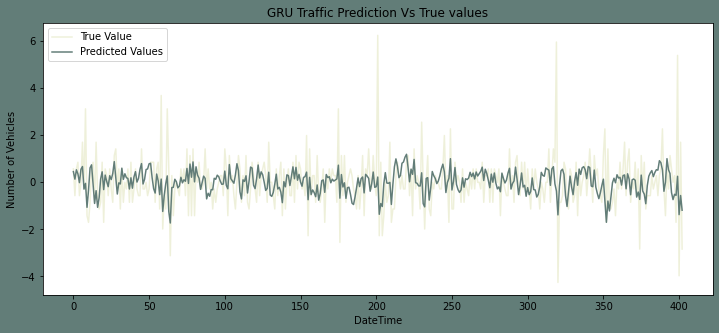

In [28]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

### The results of the model

In [34]:
# Set the data in lists to the initial error values of the four junctions.  
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]  
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]  
list_of_tuples = list(zip(Junctions, RMSE))  
# Creates pandas DataFrame.  
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])  
Results.style.background_gradient(cmap="Pastel1")    

,Junction,RMSE
0,Junction1,0.245832
1,Junction2,0.556462
2,Junction3,0.606575
3,Junction4,0.993562
